# A Style-Based Generator Architecture for Generative Adversarial Networks (StyleGAN)

[A Style-Based Generator Architecture for Generative Adversarial Networks](https://arxiv.org/abs/1812.04948)

본 model은 discrimintator나 loss function은 건들이지 않고, style을 더 잘 학습시키도록 generator의 architecture를 발전시킨 모델입니다.

기존의 PGGAN(ProGAN) 모델 (기존의 GAN보다 고해상도의 이미지를 생성)을 변형시켜 image합성을 style scale-specific cotrol 할 수 있도록 발전시켰습니다.

아래의 사진처럼 특정 style을 scaling할 수 있는 것이 style scale-specific control 이다.

### 1. Introduction
---

본 논문은 style transfer literature를 기존의 generator에 적용하였습니다.

latent vetor z 에 style을 넣을 수 있도록 learned constant input w (mapping network를 통해 학습된 parmeter)을 조금씩 조정해 주었습니다.(style : w1, w2, w3…)

또한, style vector를 넣을 때 noise와 함께 넣어주어서 style간에 correlation이 없도록 했고, 자세나 identity와 같은 unsupervised separation부터 주근깨나 머리같은 stochastic variation까지 자동으로 학습할 수 있도록 하였다.

즉, scale-specific mixing과 interpolation이 가능해졌다.

> 정리하자면, StyleGAN은 latent space를 disentangle하도록 구조를 약간 수정하였으며, 추가적으로 latent space disentanglement를 측정할 수 있도록 perceptual path length와 linear separability의 2가지 metric을 제안하였다.

### 2. Style-based Generator
---
본 논문에서는 style-based generator를 사용하였습니다.

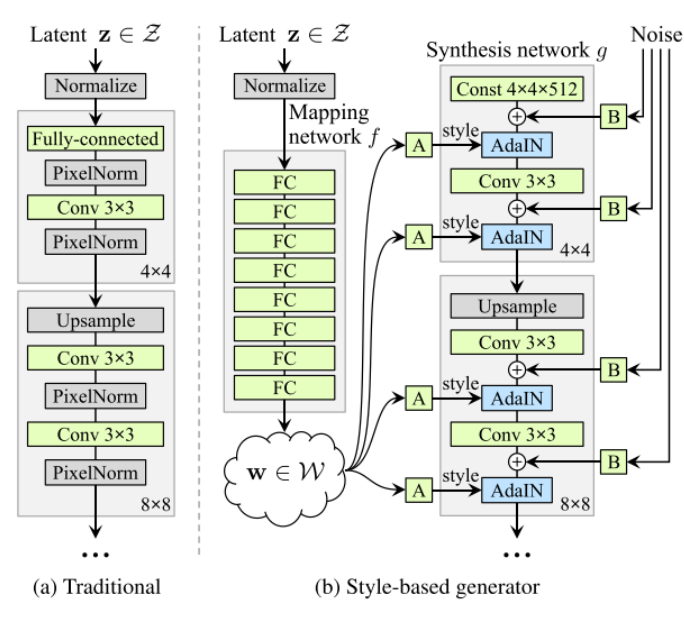

#### Traditional GAN (그림 (a))  
: latent vector가 normalize 되는 구조를 따릅니다.

- PGGAN이 이러한 구조를 따릅니다.

- 이러한 방식을 따르게 되면 training data가 latent space의 probability density를 따라야 하기 때문에 `entanglement`하게 됩니다. 즉, 주근깨나 머리처럼 stochastic variation을 변경하는데 제한이 생기게 됩니다. (각 feature들이 correlation을 갖게 되어 주근깨를 넣으려고 했는데, 머리색깔이 바뀌게 되거나 하는 현상이 발생합니다.)

> StyleGAN은 이러한 문제를 해결하고자 latent vector z를 generator의 input으로 바로 사용하지 않고, latent vector를 non-linear mapping network에 넣어 disentanglement하게 만들고자 하였습니다. (각 feature들이 상관관계를 갖지 않도록 보정합니다.)

#### Style-based Generator (그림 (b))

> 우선 latent space Z 에서 non-linear mapping network f : Z → W 를 거쳐 style code w ∈ W 를 생성합니다. (W : intermediate latent space)

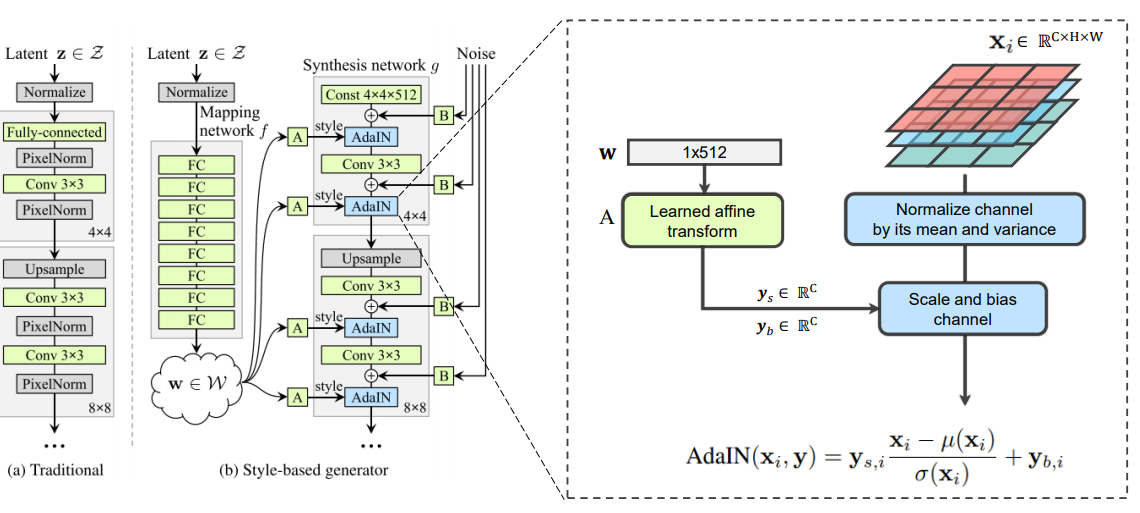

> 이후에는 각 convolutional layer에 있는 adaptive instance normalization (AdaIN) 을 사용해서 generator를 조절해 줍니다.

#### Mapping Network
---
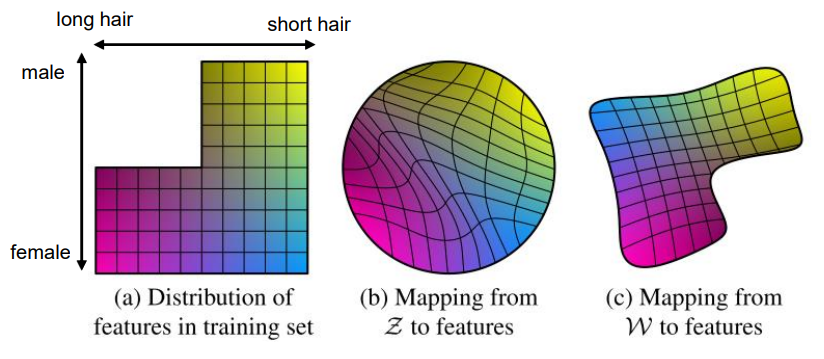

본 논문에서는 latent z를 곧바로 Synthesis Network에 넣어주는 것이 아니라, Mapping Network를 통해 w를 매핑한 후, w를 넣어줍니다. 논문에서는 이것에 대한 이유를 disentanglement라고 설명합니다.

위 이미지는 Disentanglement에 관하여 논문에 실린 이미지 입니다.

본 논문에선 Disentanglement 를 “latent space that consists of linear subspaces, each of which controls one factor of variation” 라고 정의 합니다.

이를 쉽게 이야기하자면,  z의 특정한 값을 바꿨을 때 생성되는 이미지의 하나의 특성(성별, 머리카락의 길이, 바라보는 방향 등)만 영향을 주게 되면 disentanglement라고 할 수 있습니다.

Traditional 에서는 z를 바로 input으로 넣어주는데, 그러면 고정된 z의 분포를 training set 분포에 맞추려고 하기 때문에 disentangled 하지 못하게 됩니다. 위 그림에서도 볼 수 있듯이 만약 training set에 missing combination이 있다면, Z는 이러한 이상한 combination이 나오지 않도록 하기 위해 curved 되서 entangled하게 됩니다.

하지만, W를 feature에 매핑하는 경우에는 다릅니다. W는 Z처럼 고정된 분포를 따르지 않습니다. sampling density는 학습된 piecewise continuous mapping f(z) (f는 mapping network 입니다)에 의해 정해지게 됩니다. 따라서, warping(틀어짐)이 많이 일어나지 않습니다. 그렇기 때문에 factors of variation은 더욱 linear하고, disentangled 하다고 할 수 있습니다. 이것이 바로 `z를 곧바로 feature에 매핑하는 것보다 w에 매핑하는 것의 장점`입니다.

#### Synthesis Network

위에서의 Mapping network f를 통과한 w를 사용해서 해당 텐서에 이미지를 입히는 과정을 거칩니다.

Synthesis Network는 처음 4x4x512짜리 텐서로 시작해서 1024x1024x3으로 끝나는 8개의 레이어로 이루어져 있습니다.

해당 레이어마다 upsampling과 convolution operation이 끝난 뒷부분에 AdaIN을 적용합니다.

다만, w는 512개로 AdaIN을 적용하기엔 채널 개수와 사이즈가 다르기 때문에 이곳에서 아핀 변환 (Affine transformation)을 적용합니다.

- `A-block (learned affine transform)` : style code인 w를 뽑고나면, [Affine transformation](https://ko.wikipedia.org/wiki/%EC%95%84%ED%95%80_%EB%B3%80%ED%99%98)을 통해 
w 를 style, y = (y_s,y_b)로 바꿔줍니다. 그리고 이 style들은 AdaIN(adaptive instance normalization) opeartion을 control 합니다.

(아핀 변환은 일종의 fc layer이며, 위의 모델에서 A-block은 각기 다른 파라미터를 가진 fc layer 입니다.)

-> W가 AdaIN을 통해 style을 입힐 때 shape이 안맞아 Affine Transformation을 거쳐서 shape을 맞춰줍니다.

AdaIN : feature map x_i 를 normalize한 후, style vector y 로 scaling & biasing

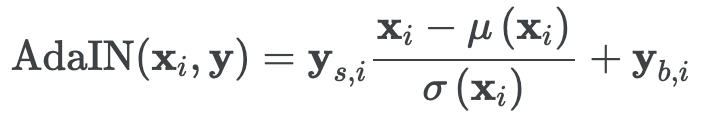

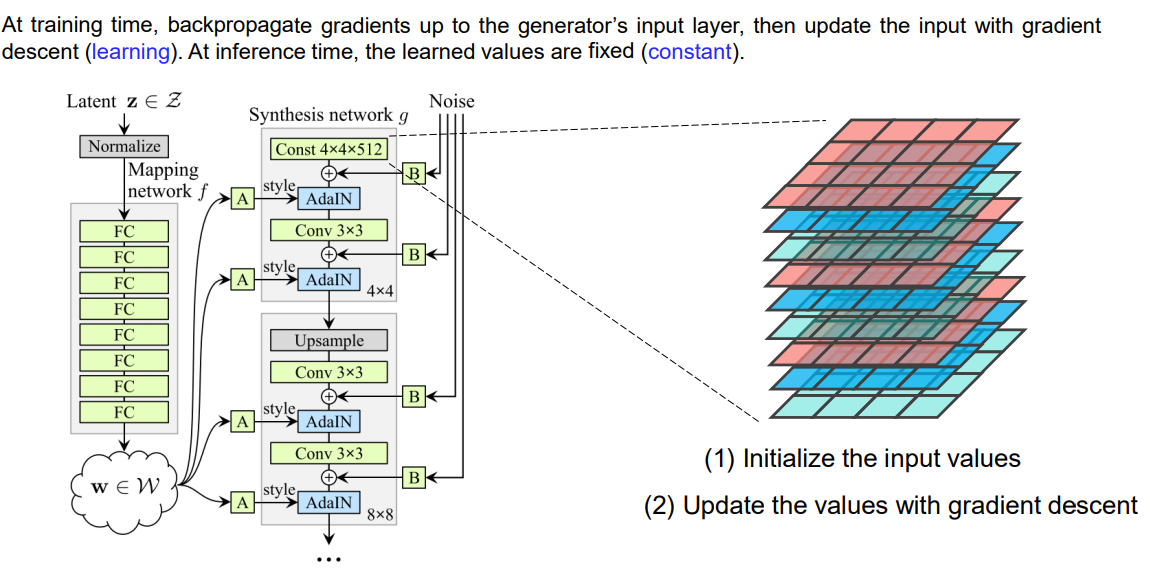

> 또한, 특이한 점은 더이상 첫번째 convolution layer의 input을 latent code에서 feeding하지 않는다는 점 입니다.
>
> 본 논문에서는 traditional input layer를 제거하고 learned constant tensor 4 x 4 x 512에서 이미지 합성을 시작합니다.

- 쉽게 말하자면, latent code를 synthesis network g 에 넣어 학습을 시키면 synthesis network의 입력으로 주었던 latent code z 는 의미가 없어집니다.
- input 자체를 학습시켰기 때문에 Learned라는 표현을 쓰며, inference시에 learned value들이 고정되어있기 때문에 Constant라는 표현을 사용하였습니다.
- 여러 가지 사진을 만들때, 왼쪽의 네트워크만 바꿔주고 오른쪽의 synthesis network는 고정합니다.

#### Noise

위에 Synthesis Network에서 결정하는 것이 high-level 특성들이라고 한다면, 이 noise를 통해 결정하는 것은 stochastic variation 입니다. stochastic variation은 머리의 세세한 결, 콧수염, 주근깨와 같이 perception of the image에 영향을 주지 않고, randomized 될 수 있는 부분들을 말합니다.

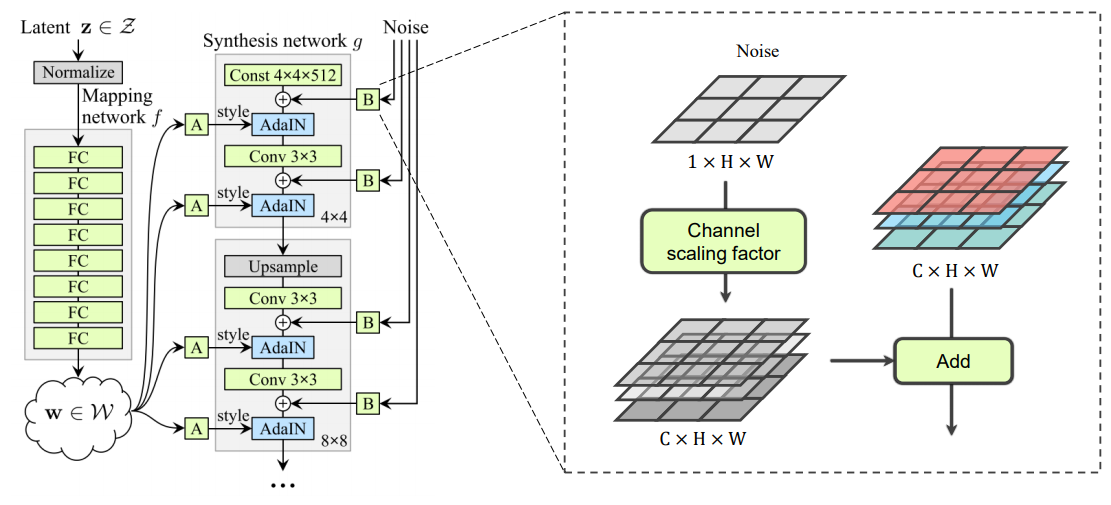

> B-block (Stochastic Variation) : 마지막으로는 stochastic detail을 생성하기 위해 각 convolution layer후에 per-pixel noise input을 넣어줍니다.

- Gaussian에서 noise를 sampling한 후, channel scaling factor를 통해 dimmension을 맞춰줍니다.

- 이때 noise값을 multiplication하게 되면 결과값이 이 noise에 너무 dependent하게 되기 때문에 단순히 add만 해줍니다. (noise를 더해주는 건 머리카락의 움직임과 같은 미세한 변화만을 조정해주기 위해 더해주는 것)

- 다음 그림을 보면, noise를 변화시킬 때마다 머리카락과 같은 stochastic detail들이 조금씩 변화하는 것을 확인 할 수 있습니다.

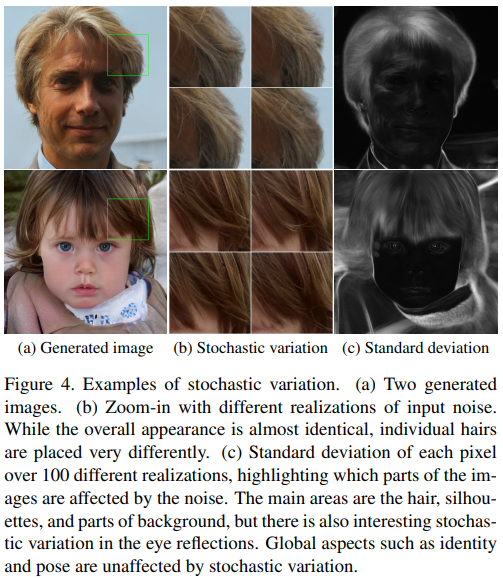

- 또한, Figure5를 보면 각 layer마다 더해지는 noise가 각기 다른 stochastic detail에 관여함을 확인할 수 있습니다.

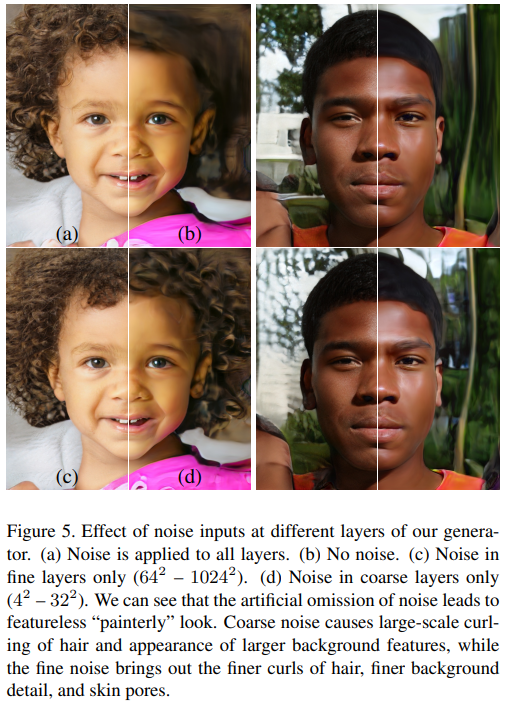

> 정리하자면, noise들은 local한 변화에만 영향을 주고 전체적인 특성을 바꾸지는 못합니다.

> A-block은 전체적인 global attribute이나 identity를 결정하고, B-block은 stochastic detail을 결정합니다.

- 저자들은 global attribute를 latent space로 modeling하려면 spatial correlation을 고려해야하지만, stochastic detail을 modeling할 때에는 전체적인 특성을 고려하지 않아도 됩니다. 따라서 detail한 변화를 주고싶을 때에는 spatially independent noise를 사용합니다.

### 3. Properties of the style-based generator
---

Our generator architecture makes it possible to control the image synthesis via scale-specific modifications to the styles.

We can view the mapping network and affine transformations as a way to draw samples for each style from a learned distribution, and the synthesis network as a way to generate a novel image based on a collection of styles

### 3-1. Style Mixing

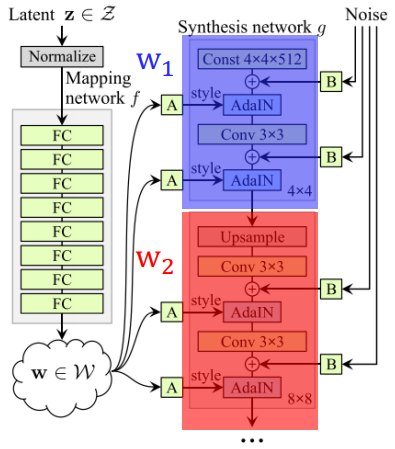

- style mixing은 단어 그대로 style을 섞어주는 것입니다. latent code 2개를 sampling (z_1,z_2)한 후, mapping network를 거쳐 2개의 style code(w_1,w_2)를 만드는 것입니다. 이후 어떠한 기준점을 정한 후, 두 개의 스타일을 넣어주면 style이 섞이게 됩니다.

- 이렇게 mixing regularization을 하게 되면 각각의 style들이 correlation되지 않게 됩니다.

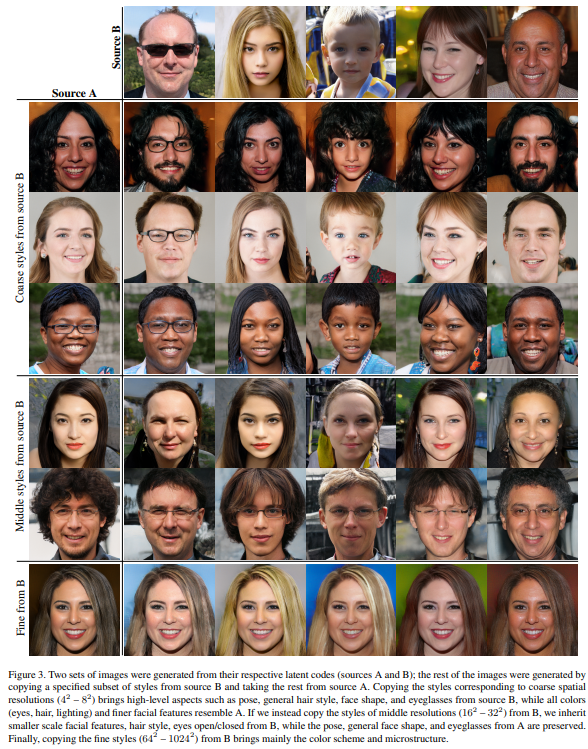

### 4. Disentanglement studies
---

- latent space 의 interpolation 정도를 측정하기 위한 2가지 metrics를 소개하였습니다.

#### 4-1. Perceptual path length (PPL)
---

latent space 에서 interpolation을 했을 때, 얼마나 큰 변화가 있는지 측정하는 것입니다. 왜 interpolation을 해서 측정을 하냐면, interpolation을 했을 때 일어나는 변화는 disentanglement와 관련이 있기 때문입니다. 예를 들어, interpolation을 했을 때 non-linear한 변화가 이미지에서 일어난다면, latent space가 entangled 할 수 있다는 것을 의미하기 때문입니다.

이를 측정하기 위해 본 논문에서는 “perceptually-based pairwise image distance”를 구합니다. 이것의 식은 아래와 같으며, 각각 Z와 W 일 경우의 distance를 구하는 공식이고, Z는 spherical interpolation을 하고, W는 linear interpolation을 하는데, W의 벡터들은 normalized 되어있지 않기 때문입니다.


- The average perceptual path length in latent space Z

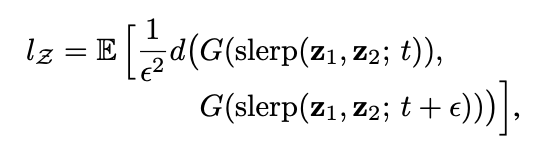

#### The average perceptual path length in latent space W

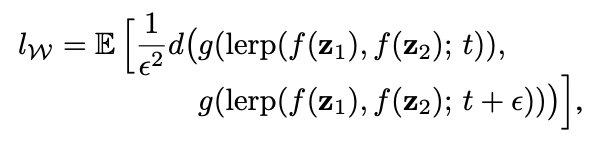

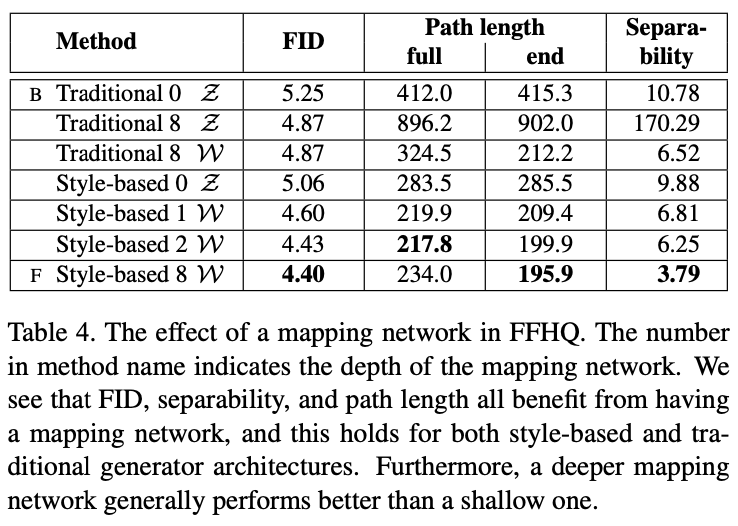

- Traditional : inject latent code into input layer only

- Style-based : inject latent code into all convolutional layers using AdalN

- number : layers in mapping network

- Z, W : latent space to measure PPL

> 위의 도표를 해석해 보자면, space Z 보다는 space W 를 사용했을 때, 일반 모델보다는 AdaIN을 사용한 style-based model을 사용했을 때 disentanglement하다는 것을 확인 할 수 있습니다.

#### 4-2. Linear separability
---
latent space가 충분히 disentangled 하다면, 각각의 factors of variation에 해당하는 방향 벡터를 찾을 수 있어야 한다고 합니다. 따라서 latent-space 점들이 linear hyperplane으로 두개로 잘 구분이 되는지를 측정합니다. 이때, 40개의 특성을 갖는 데이터 셋에서 auxiliary classification network를 이용하여 SVM으로 binary classification을 하고, 예측된 class 를 따져서 conditional entropy H(Y∣X)를 구합니다. 이때, X는 SVM으로 예측된 class를, Y는 pre-trained classifier로 예측된 class를 말합니다.

이를 이용해 sample이 true class를 결정하기 위해 additional information이 얼마나 필요한지 알 수 있고, 이로 separability score를 계산하여 metric으로 사용합니다.